In [115]:

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import transforms, datasets
import numpy as np
import matplotlib as plt
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
import os
import json
from PIL import Image
import tqdm 
from tqdm import tqdm

In [2]:
# practice

test_cnn=nn.Conv2d(3, 12, 3, stride=2, padding=1)
test_cnn
# test_input = torch.Tensor(1, 3, 36, 36)
# test_output = test_cnn1(test_input)

# test_output.shape

Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [4]:
# def _basic_block(in_channels, out_channels, stride=1):
#         """ 기본 Residual Block 구성 """
#         downsample = None
#         if stride != 1 or in_channels != out_channels:
#             downsample = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )

#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             downsample if downsample else nn.Identity(),
#             nn.ReLU(inplace=True)
#         )


# block = _basic_block(64,128)
# print(block)
# x = torch.randn(1, 64, 25, 25)
# out = block(x)
# print


In [138]:
class ResNet34(nn.Module):
    def __init__(self, num_classes=10, block_nums=[3, 4, 6, 3]):
        super().__init__()
        self.in_channels =3 # 입력 채널

        # 맨 처음 conv
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        self.batchnorm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        layer1= self.make_block(64, 64, block_nums[0])
        layer2= self.make_block(64, 128, block_nums[1])
        layer3= self.make_block(128, 256, block_nums[2])
        layer4= self.make_block(256, 512, block_nums[3])

        # self.layers = [layer1, layer2, layer3, layer4]
        self.layers = nn.ModuleList([layer1, layer2, layer3, layer4])
        self.fc = nn.Linear(512, num_classes)

        self.apply(self.init_weights)

    @torch.no_grad()
    def init_weights(self, m):
        '''가중치 초기화'''
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                #nn.init.xavier_normal(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.uniform(m.weight)           
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def basic_block(self, in_channels, out_channels, stride=1):
        '''스킵 커넥션 구간의 블록 단위 생성'''       
        # in_channel, out_channel 같지 않을때 (예: in=64, out=128)
        conv1x1=None
        if in_channels != out_channels or stride!=1:  
            conv1x1= nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride =stride, bias=False),
                nn.BatchNorm2d(out_channels)
            ) 

        # cnn 두개를 이은 블록
        out= nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            )
        
        return out, conv1x1
    
    def make_block(self, in_ch, out_ch, num):
        '''같은 채널수의 블록을 여러개 이어붙인다'''

        blocks = []
        # 처음에 적은 채널수에서 증가된 채널수로 넘어가는 과정만 예외처리
        for n in range(num):
            stride = 1 if n>0 else 2 # ??첫 블록만 stride=2 적용
            # if in_ch==out_ch and in_ch==64:
            #     stride=1
            # elif n==0:
            #     stride=2
            # else:
            #     stride=1

            block, down_sample = self.basic_block(in_ch, out_ch, stride)
            blocks.append(nn.ModuleList([block, down_sample]))
            in_ch = out_ch

        return nn.ModuleList(blocks)

    def forward(self, x):
 
        x = self.conv1(x)        
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.maxpool(x)

        for layer in self.layers:
            
            for (block, down_sample) in layer:
                skipped_x = x.clone().detach()
                out = block(x)
                if down_sample is not None:
                    skipped_x = down_sample(skipped_x)

                out += skipped_x
                result = nn.ReLU(inplace=True)(out)
                x = result    
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [81]:
# res = ResNet34()
tt = model.modules()
for t in tt:
    print(t)

ResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=512, out_features=10, bias=True)
)
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
AdaptiveAvgPool2d(output_size=(1, 1))
Linear(in_features=512, out_features=10, bias=True)


In [ ]:
'''config 데이터'''
BATCH_SIZE = 64  # 256
EPOCH = 25
initial_lr = 1e-5  # 0.1
weightDecay = 0.0001
momentum_factor = 0.9  # momentum


In [13]:
# 이렇게 사용 못함 폴더 구조로인해
dataset = ImageFolder(root='../Data/imagenet-mini',
                      transform = transforms.Compose([
                          transforms.ToTensor()
                      ]))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

print(dataset.classes)

['train.X1', 'train.X2', 'train.X3', 'train.X4', 'val.X']


In [14]:
label_path = os.path.join("../Data/imagenet-mini/Labels.json")
label_dict = {}
with open(label_path, "r") as f:
    label_dict = json.load(f)
#print(label_dict)
class_map = {key:value.split(",")[0].strip() for key, value in label_dict.items()}
# print(class_map)
print(len(class_map.keys()))
print(len([k for k in class_map.keys() if len(class_map[k])!=0]))

100
100


(343, 285)


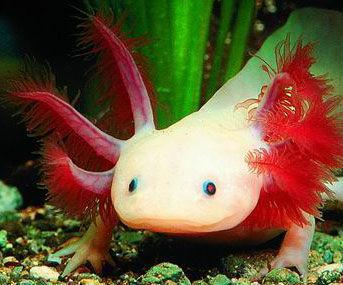

In [38]:
img_test = Image.open('../Data/imagenet-mini/train.X1/n01632777/n01632777_251.jpeg').convert("RGB")

print(img_test.size)
img_test

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, splits = ["train.X1", "train.X2", "train.X3","train.X4"], transform= None, label_file= "../Data/imagenet-mini/Labels.json"):
        '''
        Args:
            root : 상위폴더 경로
            splits : 사용할 데이터 폴더 리스트
            transform : 이미지 변환
            label_file : 라벨 파일 경로
        
        '''
        self.root_dir =root_dir
        self.splits = splits
        self.transform = transform
        self.labels = {}

        self.data = []

        label_path = label_file
        label_dict = {}
        with open(label_path, "r") as f:
            label_dict = json.load(f)
        self.labels = {key: value.split(",")[0].strip() for key, value in label_dict.items()}

        for split in self.splits:
            split_dir = os.path.join(root_dir, split)
            if not os.path.exists(split_dir):
                print("split_dir -> ",split_dir)
                continue

            for class_name in os.listdir(split_dir):

                class_dir = os.path.join(split_dir, class_name)
                class_label = self.labels.get(class_name, -1)
                if class_label==-1:
                    continue

                for img in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img)
                    self.data.append((img_path, class_label))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            image= self.transform(img)  # 224x224로 바꾸기

        return img, label


In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomDataset("../Data/imagenet-mini", splits=['train.X1'], transform=transform )
data_loader = DataLoader(dataset, batch_size= BATCH_SIZE, shuffle=False, num_workers=4)

for img,label in data_loader:
    print(img.shape, label)
    break

: 

: 

In [ ]:
test_size = int(len(dataset) * 0.2)
train_size = len(dataset)- test_size
train_dataset ,test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True, num_workers=4)
test_daaloader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle=False, num_workers=4)

SyntaxError: cannot assign to function call (872220855.py, line 2)

In [147]:
cifar_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [155]:
# CIFAR
train_dataset = datasets.CIFAR10(root="../Data/",
                                 train=True,
                                 download=True,
                                 transform=cifar_transform)
test_dataset = datasets.CIFAR10(root="../Data/",
                                train=False,
                                download=True,
                                transform=cifar_transform)

# val_size = int(len(train_dataset) * 0.1)
# train_size = len(train_dataset)- val_size
# train_dataset ,val_dataset = random_split(train_dataset, [train_size, val_size])


train_loader = torch.utils.data.DataLoader(dataset =train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        pin_memory=True)

# val_loader = torch.utils.data.DataLoader(dataset =val_dataset,
#                         batch_size=BATCH_SIZE,
#                         shuffle=True,
#                         pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        pin_memory=True)



print(f"num of train_dataset: {len(train_loader.dataset)}")
print(f"num of train classes: {len(train_dataset)}")
# print(f"num of validation classes: {len(val_dataset)}")
print(f"num of test_dataset: {len(test_loader.dataset)}")
print(f"num of test classes: {len(test_dataset.classes)}, {test_dataset.classes}")

Files already downloaded and verified
Files already downloaded and verified
num of train_dataset: 50000
num of train classes: 50000
num of test_dataset: 10000
num of test classes: 10, ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [139]:
model = ResNet34(num_classes=10)

params = model.parameters()
for p in params:
    print(p.shape)

C:\Users\user\AppData\Local\Temp\ipykernel_1740\1488371239.py:32: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  nn.init.uniform(m.weight)


torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128,

In [140]:
temp = torch.randn(1, 3, 224, 224)
t = model(temp)
print(t.shape)

torch.Size([1, 10])


In [159]:
writer = SummaryWriter('resnet_logs')

optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum_factor, weight_decay=weightDecay)
loss_func = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

model = model.to(device) #model.to(device)
model.apply(lambda m: m.to(device))

for param in model.parameters():
    param.data = param.data.to(device)
    if param.grad is not None:
        param.grad.data = param.grad.data.to(device)

# for name, param in model.named_parameters():
#     print(f"{name}: {param.device}") 

train_losses= []
train_accuracy= []

# 모델 파라미터 GPU인지 CPU인지 확인
for param in model.parameters():
    print(param.device)
    break

for epoch in range(EPOCH):

    total_loss = 0
    total_accuracy = 0
    model.train()

    for (data, label) in tqdm(train_loader):  # data.shape= (32, 3, 32, 32) , label.shape= [32]
        # GPU 이동했는지 확인함
        data = data.to(device)
        label = label.to(device).long()
        # print(f"Data Device: {data.device}, Label Device: {label.device}")
        y = model(data)
        loss= loss_func(y, label)
        
        total_loss += loss.item()
        total_accuracy += (y.argmax(dim=1)==label).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    lr_scheduler.step()

    acc = 100* total_accuracy/len(train_loader.dataset)
    train_accuracy.append(acc)
    ll = total_loss/len(train_loader.dataset)
    train_losses.append(ll)
        
    writer.add_scalar('resnet_log/train_error', 100 - train_accuracy[-1], epoch + 1)
  
    
    if (epoch + 1) % 10 == 0:
        print("Epoch %d | train_loss = %.2f |  train_acc = %.2f " % (epoch + 1, train_losses[-1], train_accuracy[-1]))

torch.save(model, os.path.join('resnet_cifar_model.pt'))

device: cuda
cuda:0


  2%|▏         | 24/1563 [00:28<30:07,  1.17s/it]


KeyboardInterrupt: 

In [144]:
model.eval()

test_accuracy= []
for (data, label) in test_loader:

    data= data.to(device)
    label = label.to(device)
    y= model(data)

    total_accuracy += (y.argmax(dim=1)==label).sum().item()

test_accuracy = 100* total_accuracy/len(test_loader.dataset)
print("TEST accruacy : %.2f" % (test_accuracy))

TEST accruacy : 74.55
